In [1]:
import pandas as pd
import torch
from treeinterpreter import treeinterpreter as ti
import seaborn as sns
import matplotlib.pyplot as plt

# Loading and testing the ChemPhys model

In [2]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
chemphys_model = torch.load(f"../models/chem_phys_rf.pkl")

test_data = pd.read_csv(f"../data/splits/chem_phys_test.csv")
test_data.drop(columns=["cmp_id"], inplace=True)
X_test, y_test = test_data.drop("label", axis=1), test_data["label"]

In [4]:
# time consuming step
prediction, bias, contributions = ti.predict(chemphys_model, X_test)

# Visualizing feature contribution 

In [5]:
feature_contributions = []

for i, prop_name in zip(contributions[0], X_test.columns):
    for j, feature in zip(i, chemphys_model.classes_.tolist()):
        feature_contributions.append(
            {"prop_name": prop_name, "contribution": j, "class": feature}
        )

len(feature_contributions)

116

In [6]:
contribution_df = pd.DataFrame(feature_contributions)
feature_importance_df = (
    contribution_df.groupby("prop_name")["contribution"].median().reset_index()
)
feature_importance_df.sort_values(by="contribution", ascending=False, inplace=True)
feature_importance_df.head(2)

,prop_name,contribution
7,num_amide_bonds,0.016601
27,smr,0.006278


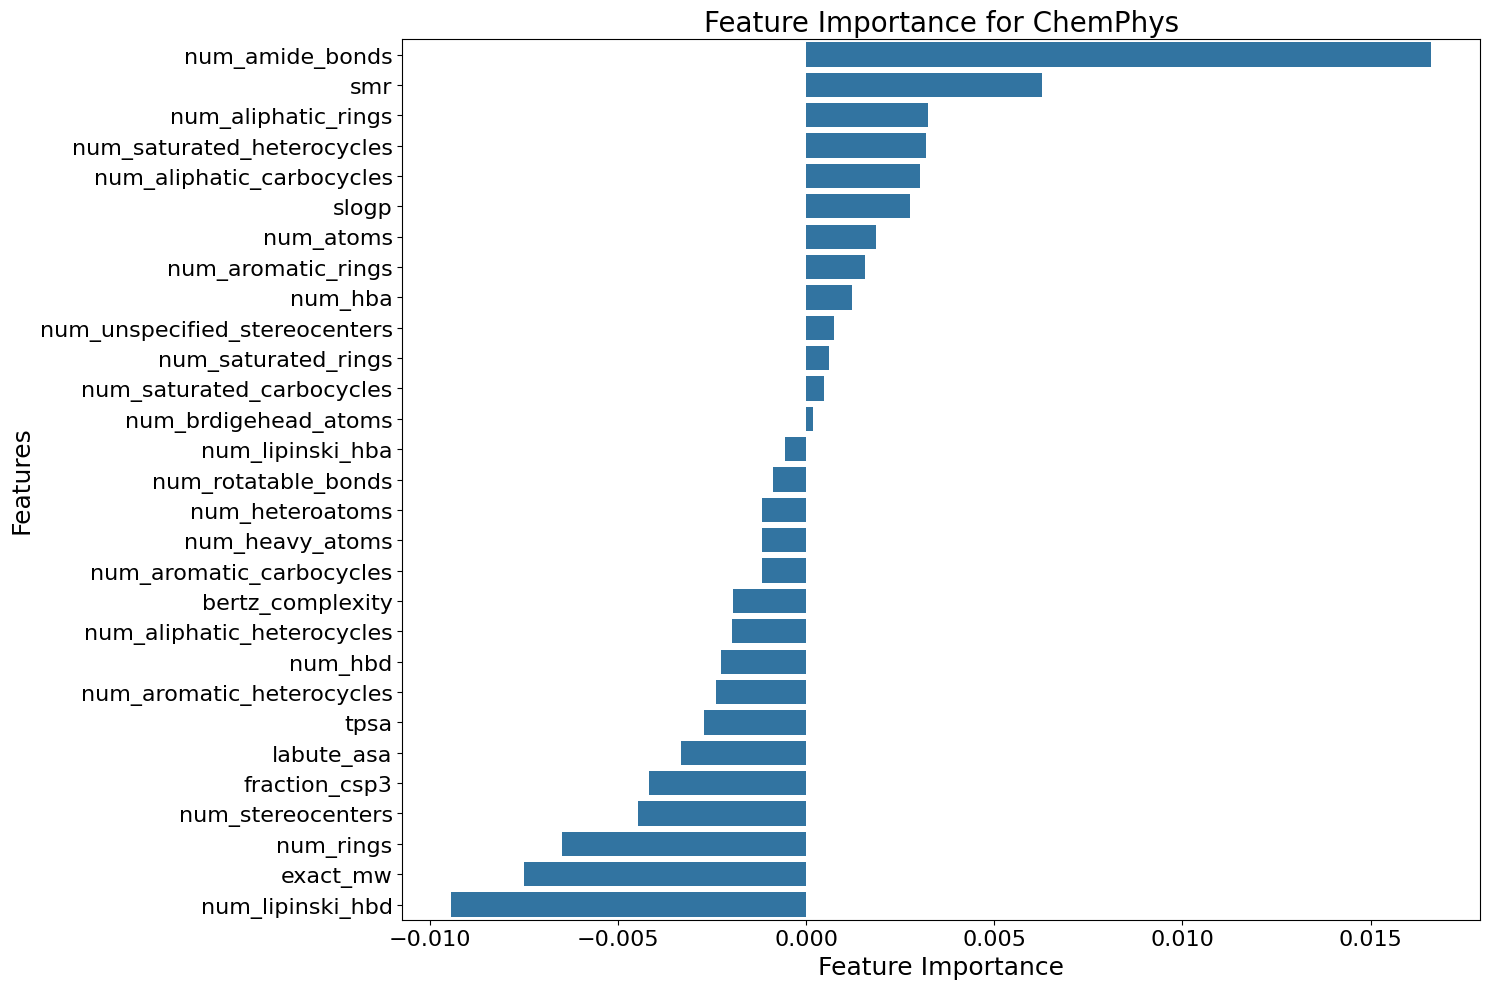

In [7]:
plt.figure(figsize=(15, 10))
sns.barplot(
    data=feature_importance_df,
    y="prop_name",
    x="contribution",
)
plt.xlabel("Feature Importance", fontsize=18)
plt.ylabel("Features", fontsize=18)
plt.title("Feature Importance for ChemPhys", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("../figures/supplementary_figure_3.png", dpi=400)
plt.show()

# Looking into their distribution in the data

In [8]:
chemphy_data = pd.read_csv("../data/fingerprints/combined_chem_phys.tsv", sep="\t")
chemphy_data["label"] = chemphy_data["label"].str.capitalize()
chemphy_data.head()

,slogp,smr,labute_asa,tpsa,exact_mw,num_lipinski_hba,num_lipinski_hbd,num_rotatable_bonds,num_hba,num_hbd,...,num_aliphatic_heterocycles,num_saturated_heterocycles,num_aromatic_carbocycles,num_aliphatic_carbocycles,num_saturated_carbocycles,fraction_csp3,num_brdigehead_atoms,bertz_complexity,cmp_id,label
0,-7.94,121.97,216.94,357.21,582.21,19,17,6,17,13,...,2,2,0,1,1,1.00,0,782.615188,OOYGSFOGFJDDHP-KMCOLRRFSA-N,Acid-fast
1,5.03,76.23,119.83,17.07,294.00,1,0,3,1,0,...,0,0,2,0,0,0.00,0,647.695192,XIPHLJFTBFXVBS-UHFFFAOYSA-N,Fungi
2,2.67,201.33,321.31,164.42,764.49,14,4,5,13,4,...,4,4,0,0,0,0.85,2,1430.680293,OEFUWWDPRNNMRS-WDPNLORNSA-N,Gram-negative
3,4.22,222.28,350.00,163.59,826.51,14,3,5,13,3,...,4,4,1,0,0,0.76,2,1770.756749,LBRXTHSVIORIGU-OLROFJLRSA-N,Gram-positive
4,2.48,106.00,166.87,74.49,421.09,7,1,3,7,1,...,2,1,1,0,0,0.37,0,1238.118476,PHYLUFIYANLQSE-UHFFFAOYSA-N,Gram-positive


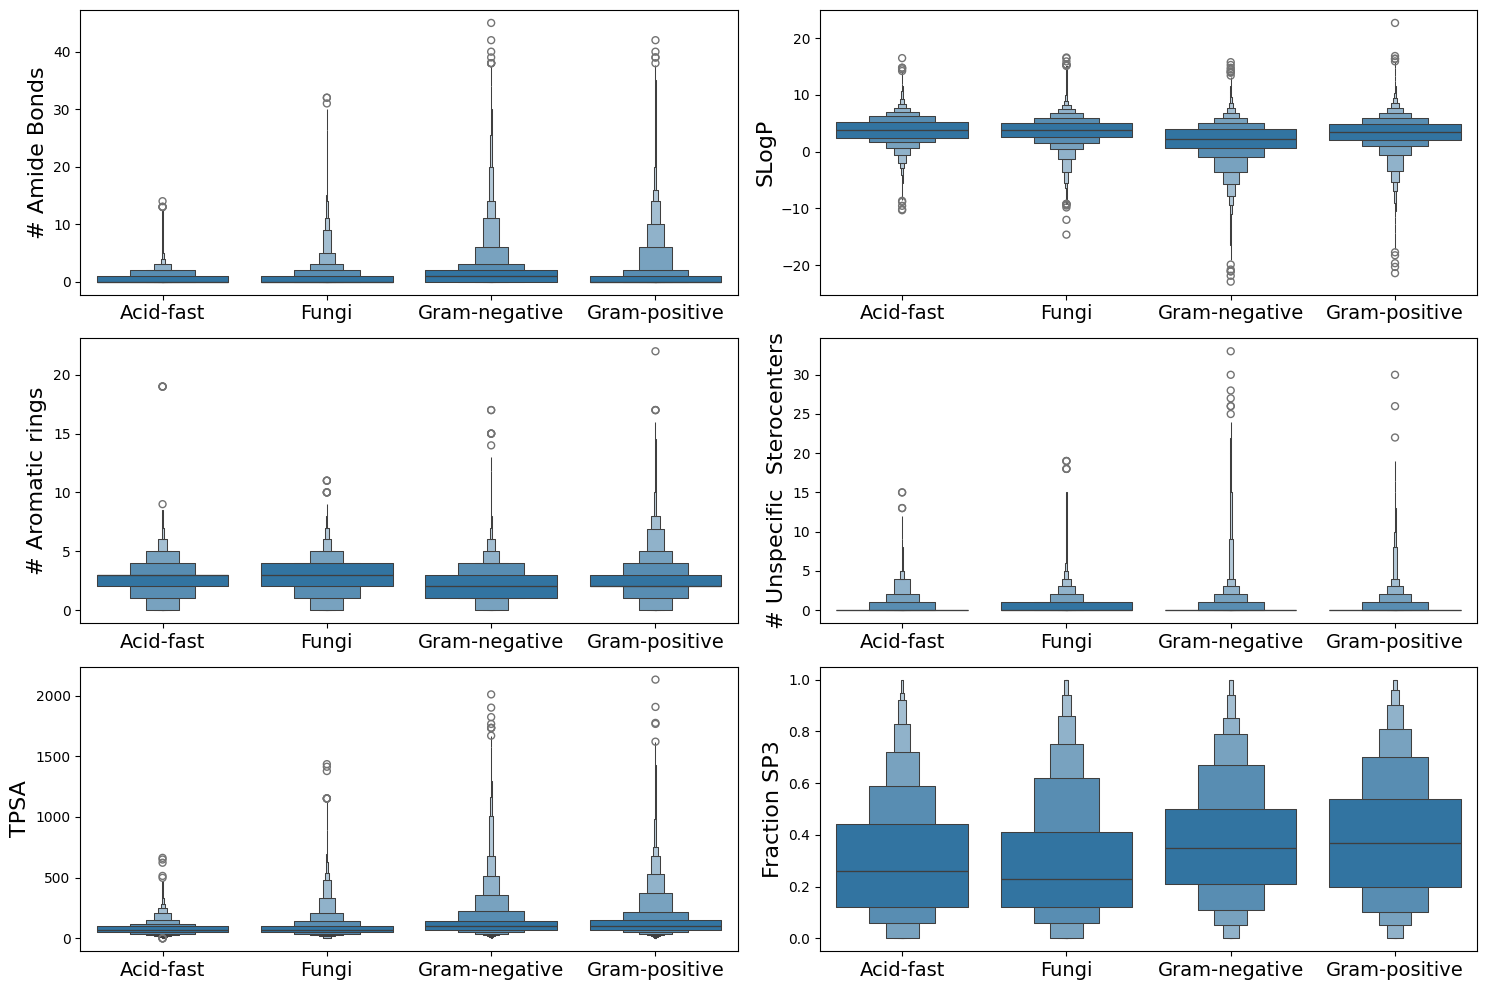

In [9]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 2, 1)
sns.boxenplot(data=chemphy_data, x="label", y="num_amide_bonds")
plt.xlabel("")
plt.ylabel("# Amide Bonds", fontsize=16)
plt.xticks(fontsize=14)
plt.xticks(fontsize=14)

plt.subplot(3, 2, 2)
sns.boxenplot(data=chemphy_data, x="label", y="slogp")
plt.xlabel("")
plt.ylabel("SLogP", fontsize=16)
plt.xticks(fontsize=14)
plt.xticks(fontsize=14)

plt.subplot(3, 2, 3)
sns.boxenplot(data=chemphy_data, x="label", y="num_aromatic_rings")
plt.xlabel("")
plt.ylabel("# Aromatic rings", fontsize=16)
plt.xticks(fontsize=14)
plt.xticks(fontsize=14)

plt.subplot(3, 2, 4)
sns.boxenplot(data=chemphy_data, x="label", y="num_unspecified_stereocenters")
plt.xlabel("")
plt.ylabel("# Unspecific  Sterocenters", fontsize=16)
plt.xticks(fontsize=14)
plt.xticks(fontsize=14)

plt.subplot(3, 2, 5)
sns.boxenplot(data=chemphy_data, x="label", y="tpsa")
plt.xlabel("")
plt.ylabel("TPSA", fontsize=16)
plt.xticks(fontsize=14)
plt.xticks(fontsize=14)

plt.subplot(3, 2, 6)
sns.boxenplot(data=chemphy_data, x="label", y="fraction_csp3")
plt.xlabel("")
plt.ylabel("Fraction SP3", fontsize=16)
plt.xticks(fontsize=14)
plt.xticks(fontsize=14)

plt.tight_layout()
plt.savefig("../figures/figure_7.png", dpi=400)
plt.show()